## Setup

In [15]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
!nvidia-smi

Tue Feb 18 19:32:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   60C    P8             14W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 25.7 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
/usr/local/lib/python3

In [4]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.2 MB/s eta 0:00:00


In [49]:
!pip install torch torchvision ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.2/915.2 kB 57.6 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Imports

In [50]:
import torch
import torchvision
import os
import requests
from PIL import Image
from torchvision import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sam2.sam2_image_predictor import SAM2ImagePredictor
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14') # Loading the Large DINO Backbone/feature extractor

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:49<00:00, 24.6MB/s]


In [25]:
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

point_labels = [1] # 1 indicates the foreground

In [18]:
def visualize_image_mask_overlay(image_path, mask):
    """
    Visualize the binary mask overlaid on the original image.

    Args:
        image_path (str): Path to the original image.
        mask (np.ndarray): Binary mask of the same size as the image.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    # Overlay the mask on the image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap="jet")  # Use transparency for the mask
    plt.title("Image with Mask Overlay")
    plt.axis("off")

    plt.show()

In [68]:
def visualize_mask(image_path, mask):
    """
    Visualize the masked part as transparent and the non-masked part as black.

    Args:
        image_path (str): Path to the original image.
        mask (np.ndarray): Binary mask of the same size as the image.
    """
    from matplotlib.colors import to_rgba

    # Load the image
    image = Image.open(image_path).convert("RGBA")  # Use RGBA for transparency
    image = np.array(image)  # Convert to NumPy array

    # Create a copy for applying transparency
    transparent_image = np.zeros_like(image)
    transparent_image[:, :, 3] = 255  # Set alpha channel to fully opaque by default

    # Mask logic: non-masked parts (where mask == 0) become black
    transparent_image[mask == 0, :3] = [0, 0, 0]  # Set RGB to black for non-masked areas
    transparent_image[mask == 0, 3] = 255         # Set alpha to fully opaque for non-masked

    # Masked part remains as transparent (alpha = 0)
    transparent_image[mask > 0, 3] = 0            # Set alpha to fully transparent for masked areas

    # Display the results
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path).convert("RGB"))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(transparent_image)
    plt.title("Masked Transparent Image")
    plt.axis("off")

    plt.show()

In [55]:
from ultralytics import YOLO
import torch
from PIL import Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Helper function to visualize bounding boxes
def visualize_yolo_boxes(image, detections, class_names):
    """
    Visualizes bounding boxes predicted by YOLOv8 on the input image.

    Args:
        image (PIL.Image or np.array): The input image.
        detections (Boxes): YOLOv8 detections (results[0].boxes).
        class_names (dict): Dictionary mapping class indices to class names (results.names).
    """
    # Convert PIL image to numpy array if needed
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Ensure the image is in RGB format
    if len(image.shape) == 2 or image.shape[2] == 1:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:  # RGBA
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    # Create a copy of the image to draw on
    image_copy = image.copy()

    for box, conf, cls in zip(detections.xyxy, detections.conf, detections.cls):
        x_min, y_min, x_max, y_max = map(int, box.tolist())
        confidence = float(conf)  # Confidence score
        class_index = int(cls)    # Class index
        class_name = class_names[class_index]  # Class name

        # Draw the bounding box
        color = (0, 255, 0)  # Green color for bounding box
        thickness = 2
        image_copy = cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color, thickness)

        # Add the label (class name and confidence)
        label = f"{class_name} {confidence:.2f}"
        font_scale = 0.5
        font_thickness = 1
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
        text_x = x_min
        text_y = y_min - 10 if y_min - 10 > 10 else y_min + 10
        cv2.rectangle(image_copy, (text_x, text_y - text_size[1]), (text_x + text_size[0], text_y), color, -1)  # Text background
        cv2.putText(image_copy, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)

    # Show the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_copy)
    plt.axis("off")
    plt.show()

In [83]:
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

['raccoon', 'cat', 'hippo', 'pig', 'gorilla', 'snow leopard', 'moose', 'black bear', 'antelope', 'noisy night monkey', 'fox', 'sheep', 'tiger', 'hamster', 'zebra', 'giraffe', 'leopard', 'dog', 'brown bear', 'panda', 'beaver', 'marmot', 'king cheetah', 'mouse', 'polar bear', 'chimpanzee', 'rat', 'cheetah', 'otter', 'wolf', 'monkey', 'panther', 'buffalo', 'horse', 'jaguar', 'rhino', 'rabbit', 'bobcat', 'weasel', 'argali sheep', 'bison', 'skunk', 'elephant', 'squirrel', 'deer', 'alouatta', 'spider monkey', 'cow', 'lion']
Using device: cuda
raccoon
No detections found for this image.


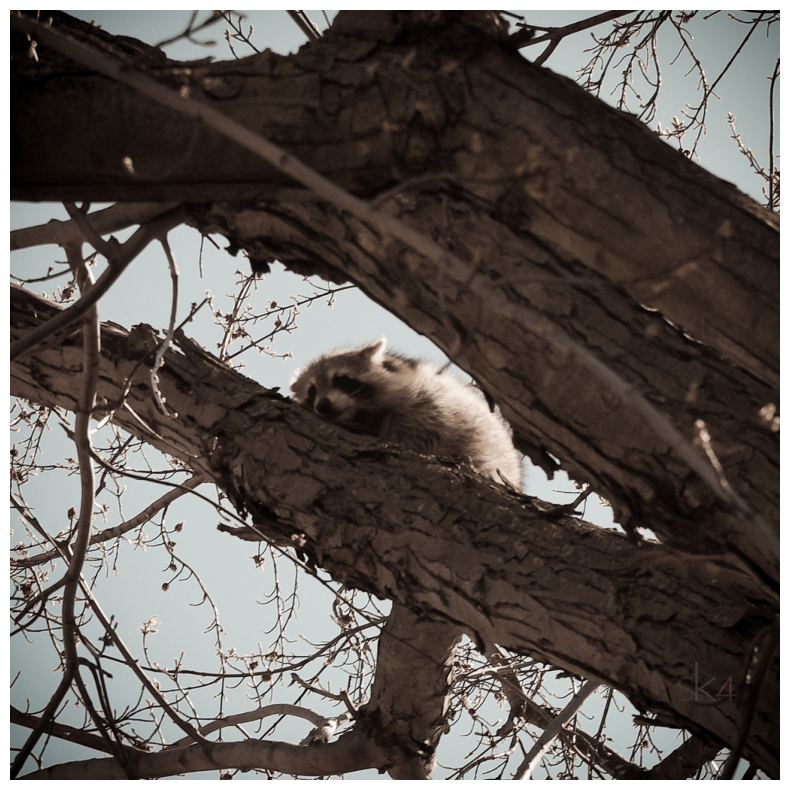

No detections found for this image.


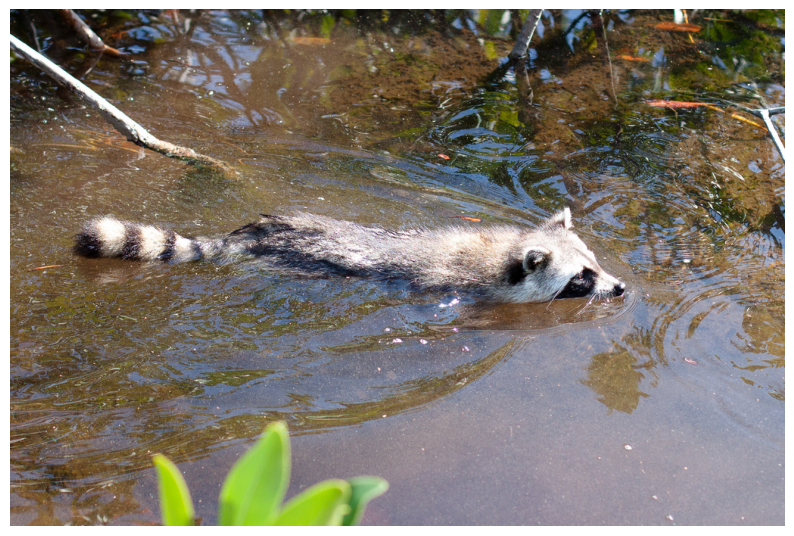

No detections found for this image.


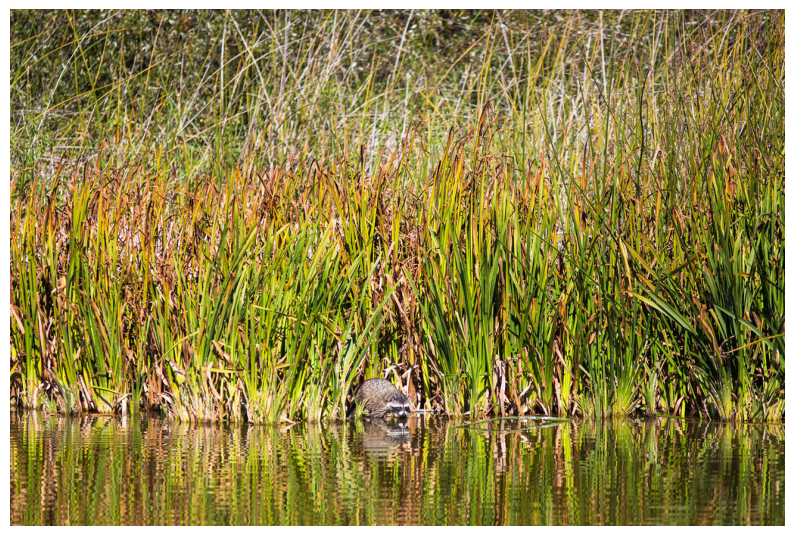

cat
No detections found for this image.


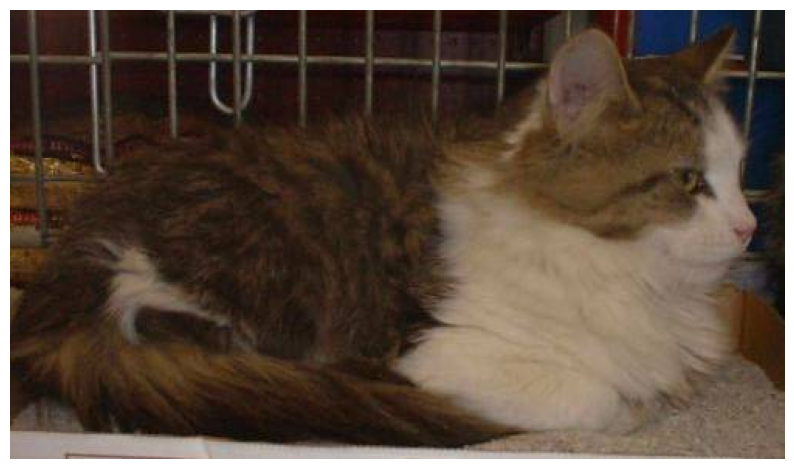

KeyboardInterrupt: 

In [87]:
patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

pca_animal = "antelope"
folder_path = "/content/drive/MyDrive/side_pose_ap10k/"
total_features  = []
pre_pca_features = []
species_features = []
species = os.listdir(folder_path)
species.remove(".DS_Store")
#print(os.path.exists(folder_path))  # Should return True if the path exists
print(species)
#root, subdir, files = os.walk(folder_path)
#print(f"result of the walk is a root: {root}, subdir: {subdir}, files: {files}")
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Assuming dinov2_vitl14 is defined and imported
# Move the model to the GPU (or CPU if no GPU is available)
model = YOLO('yolov8n.pt')
dinov2_vitl14.to(device)
predictor.model.to(device)
model.to(device)

with torch.no_grad():
    for specie in species:  # Recursively walk through all subdirectories
        print(specie)
        for file in os.listdir(os.path.join(folder_path, specie)):
            # Check if it's an image
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                #print(file)
                file_path = os.path.join(folder_path, specie, file)
                # Open the image using PIL
                image = Image.open(file_path).convert("RGB")
                image_np = np.array(image)  # Convert to numpy array for YOLOv8

                # Perform object detection with YOLOv8
                results = model(image_np, verbose=False)
                detections = results[0].boxes  # YOLOv8 detections

                # Visualize YOLOv8 predictions
                #visualize_yolo_boxes(image, detections, results[0].names)

                # Extract the confidence scores and find the index of the highest score
                confidences = detections.conf

                if confidences.numel() <= 0:
                    print("No detections found for this image.")
                    plt.figure(figsize=(10, 10))
                    plt.imshow(image)
                    plt.axis('off')  # Hide axes
                    plt.show()
                    continue  # Skip this image and continue with the next

                highest_confidence_idx = torch.argmax(confidences)  # Get index of max confidence
                # Get the bounding box with the highest confidence
                highest_confidence_box = detections.xyxy[highest_confidence_idx]
                x_min, y_min, x_max, y_max = map(int, highest_confidence_box[:4].tolist())
                #print(f"Bounding box with highest confidence: {x_min, y_min, x_max, y_max}")

                # Prepare the bounding box input for SAM
                bbox = [x_min, y_min, x_max, y_max]
                predictor.set_image(image)
                masks, _, _ = predictor.predict(box=bbox, multimask_output=True)

                # Select the mask with the largest area
                largest_mask = None
                max_area = 0
                for mask in masks:
                    # Calculate the area by counting non-zero pixels (foreground area)
                    area = mask.sum().item()  # Sum of all non-zero pixels
                    if area > max_area:
                        max_area = area
                        largest_mask = mask

                # Visualize the largest mask
                if largest_mask is not None:
                    # Convert the image to grayscale by averaging the color channels (R, G, B)
                    grayscale_image = np.dot(image_np[...,:3], [0.2989, 0.5870, 0.1140])  # Standard grayscale conversion

                    # Normalize grayscale values to [0, 1] range
                    grayscale_image = grayscale_image / 255.0

                    # Apply the mask: Set the grayscale value of the masked portion
                    grayscale_image[largest_mask == 1] = np.maximum(grayscale_image[largest_mask == 1], 0.1)

                    # Convert back to [0, 255] range for visualization (optional)
                    grayscale_image = (grayscale_image * 255).astype(np.uint8)

                    # Now apply the mask to the original image, set unmasked portion to 0 (black)
                    image_with_mask = image_np.copy()
                    image_with_mask[largest_mask == 0] = 0  # Set the unmasked portion to 0 (black)

                    # Convert the masked portion to grayscale, keeping the masked portion as grayscaled image with minimum 0.1
                    image_with_mask[largest_mask == 1] = np.expand_dims(grayscale_image, axis=-1)[largest_mask == 1]  # Apply grayscaled values to masked portion

                    # Convert to PIL image for visualization
                    #print(image_with_mask.shape)
                    final_image = Image.fromarray(image_with_mask)
                    #print(final_image.shape)

                    # Display the final image using matplotlib (this should work reliably in notebooks)
                    # plt.figure(figsize=(10, 10))
                    # plt.imshow(final_image)
                    # plt.axis('off')  # Hide axes
                    # plt.show()
                    # Or save it to a file
                    #final_image.save("output_image.png")

                    # Visualize the largest mask
                    #visualize_mask(image_path, largest_mask)

                img_t = transform1(final_image).to(device)
                features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
                features = features_dict['x_norm_patchtokens']
                total_features.append(features)
                if specie == pca_animal:
                  pre_pca_features.append(features)
        total_features = torch.cat(total_features, dim=0)
        species_features.append(total_features)
        total_features = []

pre_pca_features = torch.cat(pre_pca_features, dim=0)

## Analysis

### Quantitative Species Similarity

In [ ]:
# Dictionary to store the average feature vector for each species
species_avg_vectors = {}

for specie, species_feature in zip(species, species_features):
  num_images = species_feature.shape[0]
  species_feature = species_feature.reshape(num_images, patch_h * patch_w * feat_dim) # flattening output of each image into a vector
  avg_vector = species_feature.mean(axis=0)

  # Store the average feature vector
  species_avg_vectors[specie] = avg_vector

# Get the average feature vector for antelopes
antelope_vector = species_avg_vectors.get("antelope")
if antelope_vector is None:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

# Compute cosine similarity of all species with respect to antelopes
cosine_similarities = []
for specie, avg_vector in species_avg_vectors.items():
    similarity = cosine_similarity(avg_vector.cpu().reshape(1, -1), antelope_vector.cpu().reshape(1, -1))[0][0]
    cosine_similarities.append((specie, similarity))

# Sort species by descending cosine similarity
cosine_similarities.sort(key=lambda x: x[1], reverse=True)

# Print results
for specie, similarity in cosine_similarities:
    print(f"{specie}: {similarity:.4f}")

### PCA Visualization

##### Antelopes Images with DINOv2 PCA

In [ ]:
# 2nd PCA for only foreground patches
pca.fit(pre_pca_features[pca_features_fg].cpu())
pca_features_left = pca.transform(pre_pca_features[pca_features_fg].cpu())

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(len(image_files), patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

##### Un-altered Antelope Images

In [ ]:
# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# Loop through the first 4 images
for i, img_file in enumerate(image_files[:4]):
  img_path = os.path.join(subfolder_path, img_file)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()